<a href="https://colab.research.google.com/github/FAtheme/DL-Spring2024/blob/main/Exercise2%20-%20Fatemeh%20Barati/DL_E2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

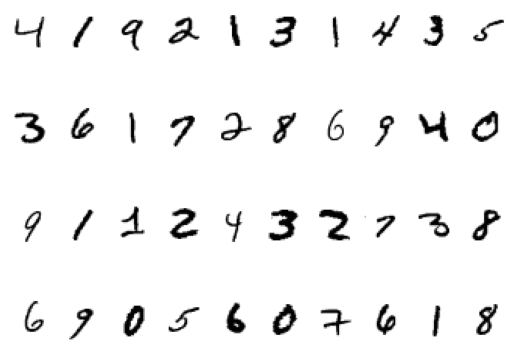

Net(
  (features): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1960, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_f

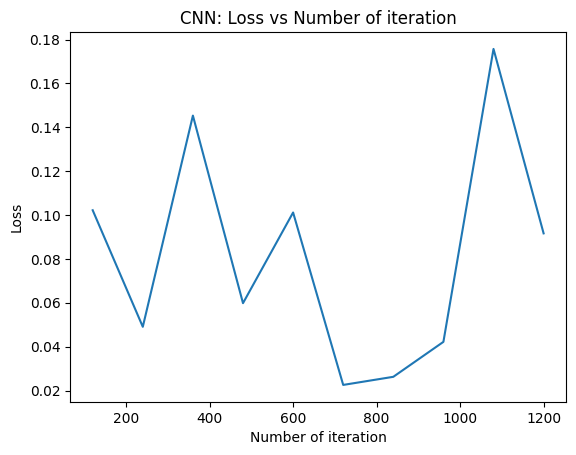

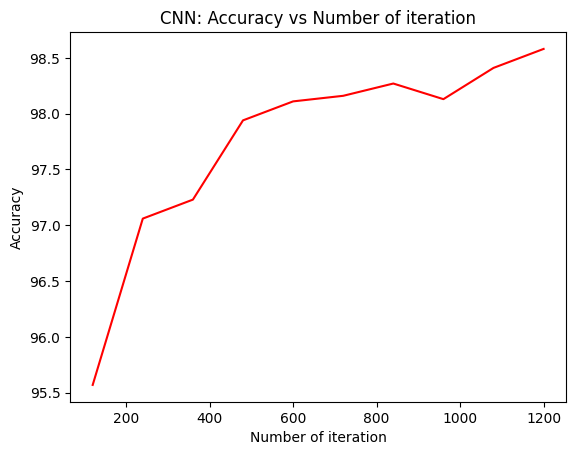

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Define the myMNIST class
class myMNIST(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.labels = self.data.iloc[:, 0].values.astype('int64')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transform the data to torch tensors and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare training set and testing set
trainset = myMNIST('https://pjreddie.com/media/files/mnist_train.csv', transform=transform)
testset = myMNIST('https://pjreddie.com/media/files/mnist_test.csv', transform=transform)

# Prepare training loader and testing loader
batch_size = 100
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Visualize some training images
figure = plt.figure()
num_of_images = 40
for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    plt.imshow(trainset.images[index], cmap='gray_r')
plt.show()

# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(40)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 40, 200),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 7 * 7 * 40)
        x = self.classifier(x)
        return x

model = Net()
print(model)

# Load criteria and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training model
num_epochs = 2
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        train, labels = data
        optimizer.zero_grad()
        outputs = model(train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        count += 1

        if count % round(len(train_loader) / 5) == 0:
            correct = 0
            total = 0
            for i, data in enumerate(test_loader, 0):
                test, labels = data
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print('Iteration: {} out of {}  Loss: {}  Accuracy: {} %'.format(count, num_epochs * len(train_loader), loss.data, accuracy))

# Visualize Loss and Accuracy over Iteration
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()